# Evaluation script for MiniBrass Evaluation results
##  WCSP-Solver Comparison

In [1]:
import sqlite3
conn = sqlite3.connect('results.db')
c = conn.cursor() 
%pylab inline
readable = { "NUMBERJACK":"Toulbar2", "GECODE":"Gecode", "OR_TOOLS":"OR-Tools", "CHOCO":"Choco",
            "JACOP":"JaCoP", "G12":"G12", "GECODE_NAT" : "Native Gecode"}

readableProblems = { "on-call-rostering":"On-Call Rostering", "mspsp":"MSPSP", "soft-queens":"Soft N-Queens",
                    "talent-scheduling":"Talent Scheduling", "photo":"Photo Placement"}
from collections import defaultdict

problemToInstance = defaultdict(list)
c.execute("SELECT Problem, Count(Distinct Instance) as Instances FROM JobResult Group By Problem")
for row in c.fetchall():
    problemToInstance[row[0]] = row[1]

    
c.execute("SELECT COUNT(*) FROM ( SELECT Distinct Instance FROM JobResult )")
res = c.fetchone()
numberProblems = res[0]

print "We tried", numberProblems, "instances."

Populating the interactive namespace from numpy and matplotlib
We tried 28 instances.


In [2]:
# now we do the solver comparison 
problemToInstance = defaultdict(list)
c.execute("SELECT Problem, Count(Distinct Instance) as Instances FROM JobResult Group By Problem")
for row in c.fetchall():
    problemToInstance[row[0]] = row[1]

    
c.execute("SELECT COUNT(*) FROM ( SELECT Distinct Instance FROM JobResult )")
res = c.fetchone()
numberProblems = res[0]

print "We tried", numberProblems, "instances."

scriptFile = open("query-native-solver-comparison-pure-views.sql", 'r')
script = scriptFile.read() 
scriptFile.close()
c.executescript(script)
conn.commit()

scriptFile = open("query-native-solver-comparison-pure.sql",'r')
script = scriptFile.read() 
scriptFile.close()

c.execute(script)

currProblem = ""
print "\\begin{tabular*}{\\textwidth}{@{\\extracolsep{\\fill} }l" + \
 "".join(["d{1.5}"  for i in range(0,1)]) + "cd{1.5}" + "".join(["d{1.1}"  for i in range(0,2)]) + "}"
print "\\toprule"
print '''\\multicolumn{1}{c}{Solver} & \multicolumn{1}{c}{Time (secs)} 
          & \multicolumn{1}{c}{\\# Wins}
          & \multicolumn{1}{c}{Objective} 
          & \multicolumn{1}{c}{\% Solved} & \multicolumn{1}{c}{\% Optimal} \\\\'''
for row in c.fetchall():
    (problem, solverId, solverName, elapsed, elapsedSpan, relElapsed, \
     objective, relObjective, wins, solved, optimally) = row
    if currProblem != problem:
        #print "Starting .... ", problem
        currProblem = problem
        print "\\midrule"
        print "\\multicolumn{2}{l}{" + readableProblems[problem] + " ("+ str(problemToInstance[problem])  + " instances)  }   \\\\"
        print "\\midrule"
    print "  ", readable[solverName], "&", '{0:.2f}'.format(elapsed),\
    "\\quad ("+'{0:.2f}'.format(relElapsed)+")" "&", '{0:.0f}'.format(wins),    \
     "&", '{0:.2f}'.format(objective), "\\quad ("+'{0:.2f}'.format(relObjective)+")", "&", \
    '{0:.2f}'.format(solved), "&",'{0:.2f}'.format(optimally), "\\\\"
print "\\bottomrule"
print "\\end{tabular*}"

We tried 28 instances.
\begin{tabular*}{\textwidth}{@{\extracolsep{\fill} }ld{1.5}cd{1.5}d{1.1}d{1.1}}
\toprule
\multicolumn{1}{c}{Solver} & \multicolumn{1}{c}{Time (secs)} 
          & \multicolumn{1}{c}{\# Wins}
          & \multicolumn{1}{c}{Objective} 
          & \multicolumn{1}{c}{\% Solved} & \multicolumn{1}{c}{\% Optimal} \\
\midrule
\multicolumn{2}{l}{MSPSP (8 instances)  }   \\
\midrule
   Gecode & 0.32 \quad (1.00)& 8 & 2.50 \quad (0.00) & 100.00 & 100.00 \\
   G12 & 0.32 \quad (1.01)& 0 & 2.50 \quad (0.00) & 100.00 & 100.00 \\
   OR-Tools & 0.33 \quad (1.05)& 0 & 2.50 \quad (0.00) & 100.00 & 100.00 \\
   JaCoP & 0.52 \quad (1.73)& 0 & 2.50 \quad (0.00) & 100.00 & 100.00 \\
   Choco & 0.70 \quad (2.46)& 0 & 2.50 \quad (0.00) & 100.00 & 100.00 \\
   Toulbar2 & 312.56 \quad (1052.07)& 0 & 29.13 \quad (26.63) & 0.00 & 0.00 \\
\midrule
\multicolumn{2}{l}{On-Call Rostering (7 instances)  }   \\
\midrule
   Toulbar2 & 40.73 \quad (1.44)& 3 & 1.57 \quad (0.00) & 100.00 & 100.00 \\


## Native (weighted CSP) versus Smyth-based Model
### Weighted / Smyth

### Domination BaB - NonDom Bab

In [3]:


scriptFile = open("query-dom-vs-nondom-views.sql",'r')
script = scriptFile.read() 
scriptFile.close()

c.executescript(script)
conn.commit()

scriptFile = open("query-dom-vs-nondom-query.sql",'r')
script = scriptFile.read() 
scriptFile.close()

currProblem = ""
print "\\begin{tabular*}{\\textwidth}{@{\\extracolsep{\\fill} }l" + \
 "".join(["d{1.1}"  for i in range(0,4)]) + "}"
print "\\toprule"
print '''\\multicolumn{1}{c}{Problem} & \multicolumn{1}{c}{Time Non-Dominated BaB} 
          & \multicolumn{1}{c}{Time Strict BaB} 
          & \multicolumn{1}{c}{Absolute Overhead}
          & \multicolumn{1}{c}{Relative Overhead}   \\\\'''
print "\\midrule"
c.execute(script)

def boldify(floatStr):
    split_num = floatStr.split('.')
    return "\\textbf{" + split_num[0]+"}.\\textbf{"+split_num[1] + "}"


for row in c.fetchall():
    (problem, nonDomElapsed, domElapsed, absoluteOverhead, relOverhead) = row
    
    if domElapsed < nonDomElapsed:
        domElapsedText = boldify('{0:.2f}'.format(domElapsed)) 
        nonDomElapsedText = '{0:.2f}'.format(nonDomElapsed)
    else:
        nonDomElapsedText = boldify('{0:.2f}'.format(nonDomElapsed)) 
        domElapsedText = '{0:.2f}'.format(domElapsed)
        
    print "  ", readableProblems[problem], \
    "&",  nonDomElapsedText,\
    "&", domElapsedText, "&", \
    '{0:.2f}'.format(absoluteOverhead), \
    "&", '{0:.2f}'.format(relOverhead), "\\\\"

scriptFile = open("query-dom-vs-nondom-overall.sql",'r')
script = scriptFile.read() 
scriptFile.close()
print "\\midrule"
c.execute(script)
for row in c.fetchall():
    (problem, nonDomElapsed, domElapsed, absoluteOverhead, relOverhead) = row
    
    if domElapsed < nonDomElapsed:
        domElapsedText = boldify('{0:.2f}'.format(domElapsed)) 
        nonDomElapsedText = '{0:.2f}'.format(nonDomElapsed)
    else:
        nonDomElapsedText = boldify('{0:.2f}'.format(nonDomElapsed)) 
        domElapsedText = '{0:.2f}'.format(domElapsed)
        
    print problem, \
    "&",  nonDomElapsedText,\
    "&", domElapsedText, "&", \
    '{0:.2f}'.format(absoluteOverhead), \
    "&", '{0:.2f}'.format(relOverhead), "\\\\"

# query-dom-vs-nondom-overall.sql
print "\\bottomrule"
print "\\end{tabular*}"

\begin{tabular*}{\textwidth}{@{\extracolsep{\fill} }ld{1.1}d{1.1}d{1.1}d{1.1}}
\toprule
\multicolumn{1}{c}{Problem} & \multicolumn{1}{c}{Time Non-Dominated BaB} 
          & \multicolumn{1}{c}{Time Strict BaB} 
          & \multicolumn{1}{c}{Absolute Overhead}
          & \multicolumn{1}{c}{Relative Overhead}   \\
\midrule
   MSPSP & \textbf{7}.\textbf{31} & 8.89 & -1.58 & 1.50 \\
   On-Call Rostering & 329.44 & \textbf{199}.\textbf{21} & 130.23 & 1.82 \\
   Photo Placement & 55.09 & \textbf{7}.\textbf{51} & 47.58 & 9.72 \\
   Soft N-Queens & \textbf{2}.\textbf{24} & 3.65 & -1.41 & 1.91 \\
   Talent Scheduling & 33.44 & \textbf{12}.\textbf{24} & 21.21 & 2.30 \\
\midrule
\emph{Overall} & 102.00 & \textbf{57}.\textbf{20} & 44.80 & 2.97 \\
\bottomrule
\end{tabular*}


## Most Important First 

In [4]:

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

In [19]:
# first the views
scriptFile = open("query-mif-comp.sql",'r')
script = scriptFile.read() 
c.executescript(script)
conn.commit()
scriptFile.close()

# then the highest-level aggregation
scriptFile = open("query-mif-comp-summary-couting.sql",'r')
script = scriptFile.read() 
scriptFile.close()

c.execute(script)
(avgDiff, sumMifWins, insts, ratio) = c.fetchone()

print "Over all", insts, "runs across solvers, problem instances and search types, the MIF heuristic " \
"led to a faster runtime in", sumMifWins, "cases", "("+'{0:.2f}'.format(ratio)+" \%) with the average runtime reduced by "+ \
'{0:.2f}'.format(abs(avgDiff)) +" seconds."

scriptFile = open("query-mif-comp-solver.sql",'r')
script = scriptFile.read() 
scriptFile.close()

c.execute(script)

timeDiffs = defaultdict(list)
mifElapseds = defaultdict(list)
mifStds = defaultdict(list)
normalElapseds = defaultdict(list)
normalStds = defaultdict(list)
mifWinss = defaultdict(list)
instances = defaultdict(list)
ratios = defaultdict(list)
solvers = []

for row in c.fetchall():
    (solverName, mifElapsed, mifVar, normalElapsed, normalVar, timeDiff, mifWins, overall, ratio) = row
    solvers += [solverName]
    timeDiffs[solverName] = timeDiff
    mifElapseds[solverName] = mifElapsed
    mifStds[solverName] = np.sqrt(mifVar)
    normalElapseds[solverName] = normalElapsed
    normalStds[solverName] = np.sqrt(normalVar)
    mifWinss[solverName] = mifWins
    instances[solverName] = overall
    ratios[solverName] = ratio
    
print solvers
print overall, "instances are included in these averages."
print "\\begin{tabular*}{\\textwidth}{@{\\extracolsep{\\fill} }l" + \
 "".join(["d{1.1}"  for s in [1]+solvers]) + "}"
print "\\toprule"
print " & ", " & ".join(["\\multicolumn{1}{c}{" + readable[s] +"}" for s in solvers]), "\\\\"
print "\\midrule"
print "Instances & ", " & ".join(['{0:.0f}'.format(instances[s]) for s in solvers]), "\\\\"
print "Runtime difference & ", " & ".join(['{0:.2f}'.format(timeDiffs[s]) for s in solvers]), "\\\\"
#print "# MIF wins & ", " & ".join(['{0:.2f}'.format(timeDiffs[s]) for s in solvers]), "\\\\"
print "Ratio MIF wins & ", " & ".join(['{0:.2f}'.format(ratios[s]) for s in solvers]), "\\\\"
#print "Runtime difference & ", " & ".join(['{0:.2f}'.format(timeDiffs[s]) for s in solvers]), "\\\\"
print "\\bottomrule"
print "\\end{tabular*}"

Over all 196 runs across solvers, problem instances and search types, the MIF heuristic led to a faster runtime in 78 cases (0.40 \%) with the average runtime reduced by 7.98 seconds.
[u'CHOCO', u'G12', u'GECODE', u'GECODE_NAT', u'JACOP', u'NUMBERJACK', u'OR_TOOLS']
28 instances are included in these averages.
\begin{tabular*}{\textwidth}{@{\extracolsep{\fill} }ld{1.1}d{1.1}d{1.1}d{1.1}d{1.1}d{1.1}d{1.1}d{1.1}}
\toprule
 &  \multicolumn{1}{c}{Choco} & \multicolumn{1}{c}{G12} & \multicolumn{1}{c}{Gecode} & \multicolumn{1}{c}{Native Gecode} & \multicolumn{1}{c}{JaCoP} & \multicolumn{1}{c}{Toulbar2} & \multicolumn{1}{c}{OR-Tools} \\
\midrule
Instances &  28 & 28 & 28 & 28 & 28 & 28 & 28 \\
Runtime difference &  -73.14 & -17.57 & -18.42 & -18.53 & 16.15 & 36.63 & 19.05 \\
Ratio MIF wins &  0.64 & 0.32 & 0.29 & 0.18 & 0.46 & 0.57 & 0.32 \\
\bottomrule
\end{tabular*}


[28.647142857142853, 125.77785714285714, 121.18214285714285, 121.12928571428573, 121.35285714285712, 175.8017857142857, 116.43928571428572]
[87.550074767739261, 229.8720152972883, 232.45356625966554, 232.35712207303058, 238.36563786180531, 223.24574936048731, 231.66373612459091]
[101.785, 143.34714285714284, 139.60464285714286, 139.6589285714286, 105.20178571428572, 139.17178571428573, 97.38607142857144]
[215.17561071466386, 244.11789395490774, 243.53179854680965, 243.52803285892523, 217.55128415179934, 182.15353716132623, 218.40091451174447]


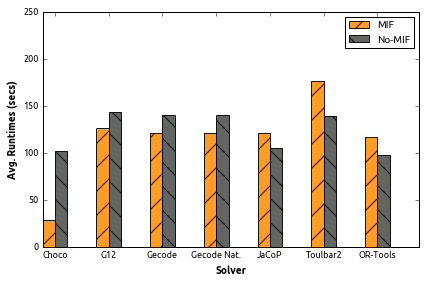

In [20]:
"""
Bar chart demo with pairs of bars grouped for easy comparison.
"""
import numpy as np
isseorange = (1.0, 0.57647, 0.039216)
#\definecolor{issegrey}{RGB}{80,85,82}
issegrey = (80.0 / 255, 85.0 / 255, 82.0 / 255)

n_groups = len(solvers)

means_mif = [mifElapseds[s] for s in solvers]
std_mif = [mifStds[s] for s in solvers]
print means_mif
print std_mif 

means_nomif =  [normalElapseds[s] for s in solvers]
std_nomif = [normalStds[s] for s in solvers]
print means_nomif
print std_nomif

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.23

opacity = 0.9
error_config = {'ecolor': '0.3'}
plt.ylim([0,250])
plt.xlim([0,7])
rects1 = plt.bar(index, means_mif, bar_width,
                 alpha=opacity,
                 color=isseorange,
                 error_kw=error_config,
                 hatch="/",
                 label='MIF')

rects2 = plt.bar(index + bar_width, means_nomif, bar_width,
                 alpha=opacity,
                 color=issegrey,
                 hatch="\\",
                 error_kw=error_config,
                 label='No-MIF')

plt.xlabel('Solver')
plt.ylabel('Avg. Runtimes (secs)')
#plt.title('Runtimes by solver and heuristic')
plt.xticks(index + bar_width , ["Choco", "G12", "Gecode", "Gecode Nat.", "JaCoP", "Toulbar2", "OR-Tools"])          
#           [ s if s != "NUMBERJACK" else "TOULBAR2"  for s in solvers])
plt.legend()

plt.tight_layout()

# plt.savefig('runtime-mif-solver.pdf', bbox_inches='tight')
plt.show()

In [21]:

scriptFile = open("query-mif-comp-problems.sql",'r')
script = scriptFile.read() 
scriptFile.close()

c.execute(script)

timeDiffs = defaultdict(list)
relTimeDiffs = defaultdict(list)
mifElapseds = defaultdict(list)
mifStds = defaultdict(list)
normalElapseds = defaultdict(list)
normalStds = defaultdict(list)
mifWinss = defaultdict(list)
instances = defaultdict(list)
ratios = defaultdict(list)
problems = []

for row in c.fetchall():
    (problem,  mifElapsed, mifVar, normalElapsed, normalVar, timeDiff, relTimeDiff, mifWins, overall, ratio) = row
    problems += [problem]
    timeDiffs[problem] = timeDiff
    relTimeDiffs[problem] = relTimeDiff
    mifElapseds[problem] = mifElapsed
    mifStds[problem] = np.sqrt(mifVar)
    normalElapseds[problem] = normalElapsed
    normalStds[problem] = np.sqrt(normalVar)
    mifWinss[problem] = mifWins
    instances[problem] = overall
    ratios[problem] = ratio
    #print row
    
print problems
print overall, "instances are included in these averages."
print "\\begin{tabular*}{\\textwidth}{@{\\extracolsep{\\fill} }l" + \
 "".join(["d{1.1}"  for p in [1]+problems]) + "}"
print "\\toprule"
print " & ", " & ".join(["\\multicolumn{1}{c}{" + readableProblems[s] + "}" for s in problems]), "\\\\"
print "\\midrule"
print "Instances & ", " & ".join(['{0:.0f}'.format(instances[s]) for s in problems]), "\\\\"
print "Runtime difference & ", " & ".join(['{0:.2f}'.format(timeDiffs[s]) for s in problems]), "\\\\"
print "Rel. runtime difference & ", " & ".join(['{0:.2f}'.format(relTimeDiffs[s]) for s in problems]), "\\\\"
#print "# MIF wins & ", " & ".join(['{0:.2f}'.format(timeDiffs[s]) for s in solvers]), "\\\\"
print "Ratio MIF wins & ", " & ".join(['{0:.2f}'.format(ratios[s]) for s in problems]), "\\\\"
#print "Runtime difference & ", " & ".join(['{0:.2f}'.format(timeDiffs[s]) for s in solvers]), "\\\\"
print "\\bottomrule"
print "\\end{tabular*}"

[u'mspsp', u'on-call-rostering', u'photo', u'soft-queens', u'talent-scheduling']
49 instances are included in these averages.
\begin{tabular*}{\textwidth}{@{\extracolsep{\fill} }ld{1.1}d{1.1}d{1.1}d{1.1}d{1.1}d{1.1}}
\toprule
 &  \multicolumn{1}{c}{MSPSP} & \multicolumn{1}{c}{On-Call Rostering} & \multicolumn{1}{c}{Photo Placement} & \multicolumn{1}{c}{Soft N-Queens} & \multicolumn{1}{c}{Talent Scheduling} \\
\midrule
Instances &  56 & 49 & 21 & 21 & 49 \\
Runtime difference &  -0.68 & -26.63 & 145.93 & -98.15 & -24.96 \\
Rel. runtime difference &  1.09 & 0.92 & 26.38 & 0.76 & 1.70 \\
Ratio MIF wins &  0.36 & 0.51 & 0.05 & 0.52 & 0.43 \\
\bottomrule
\end{tabular*}


[44.323571428571434, 215.67285714285714, 157.0947619047619, 0.1285714285714286, 129.3361224489796]
[131.36870417738348, 279.60997796858362, 239.62142969233875, 0.13712301443753114, 222.36963233995198]
[45.008035714285725, 242.30204081632658, 11.166190476190476, 98.27904761904765, 154.30102040816325]
[133.31318329701844, 295.91406322823394, 21.60819145297636, 220.08952541884622, 215.50884675477016]


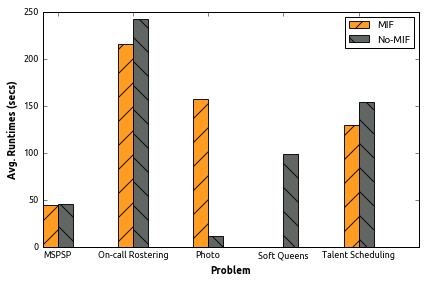

In [22]:
"""
Bar chart demo with pairs of bars grouped for easy comparison.
"""
import numpy as np
isseorange = (1.0, 0.57647, 0.039216)
#\definecolor{issegrey}{RGB}{80,85,82}
issegrey = (80.0 / 255, 85.0 / 255, 82.0 / 255)

n_groups = len(problems)

means_mif = [mifElapseds[p] for p in problems]
std_mif = [mifStds[p] for p in problems]
print means_mif
print std_mif 

means_nomif =  [normalElapseds[p] for p in problems]
std_nomif = [normalStds[p] for p in problems]
print means_nomif
print std_nomif

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.2

opacity = 0.9
error_config = {'ecolor': '0.3'}
plt.ylim([0,250])
plt.xlim([0,5])
rects1 = plt.bar(index, means_mif, bar_width,
                 alpha=opacity,
                 color=isseorange,
                 error_kw=error_config,
                 hatch="/",
                 label='MIF')

rects2 = plt.bar(index + bar_width, means_nomif, bar_width,
                 alpha=opacity,
                 color=issegrey,
                 hatch="\\",
                 error_kw=error_config,
                 label='No-MIF')

plt.xlabel('Problem')
plt.ylabel('Avg. Runtimes (secs)')
#plt.title('Runtimes by problem and heuristic')
plt.xticks(index + bar_width , ["MSPSP", "On-call Rostering", "Photo", "Soft Queens", "Talent Scheduling"])
plt.legend()

plt.tight_layout()

plt.savefig('runtime-mif-problem.pdf', bbox_inches='tight')
plt.show()

In [23]:
import numpy as np
import scipy.stats as st

scriptFile = open("query-mif-stat.sql",'r')
script = scriptFile.read() 
scriptFile.close()

c.execute(script)

mifElapseds = []
normalElapseds = []

for row in c.fetchall():
    (mifElapsed, normalElapsed) = row
    mifElapseds += [mifElapsed]
    normalElapseds += [normalElapsed]

mif = np.array(mifElapseds)
noMif = np.array(normalElapseds)

print "MIF: ", np.mean(mif), " - ", np.std(mif)
print "No MIF: ", np.mean(noMif), " - ", np.std(noMif)

[t, prob] = st.wilcoxon(mif, noMif)

if prob < 0.01:
    print "SIGNIFICANT t=", t, " prob = ", prob
else:
    print "insignificant t=", t, " prob = ", prob
    


MIF:  115.761479592  -  220.466898685
No MIF:  123.736479592  -  225.313450617
insignificant t= 3251.5  prob =  0.119937419928


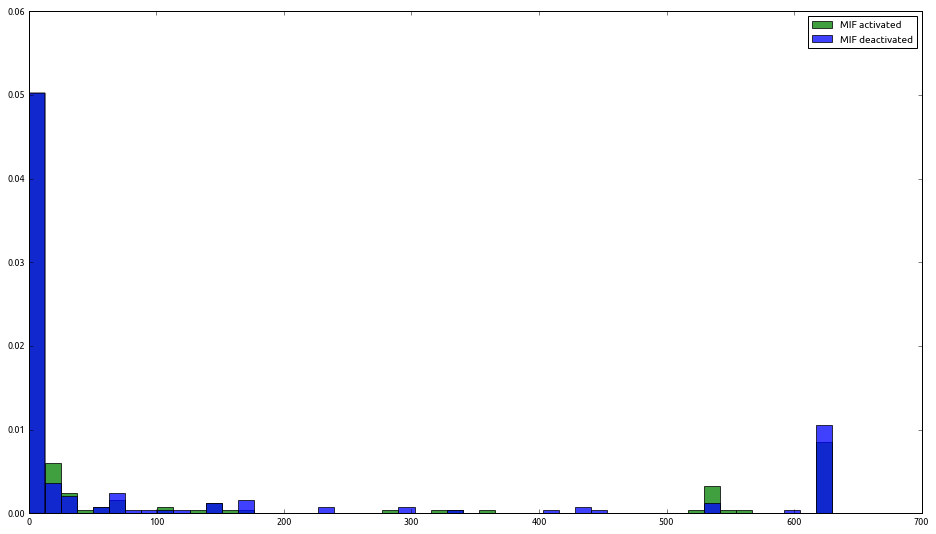

In [24]:
figure(figsize=(16,9))
n, bins, patches = plt.hist(mif, 50, normed=1, facecolor='green', alpha=0.75, label = "MIF activated")
n, bins, patches = plt.hist(noMif, 50, normed=1, facecolor='blue', alpha=0.75, label = "MIF deactivated")
legend()

In [43]:

scriptFile = open("query-mif-stat-prob.sql",'r')
script = scriptFile.read() 
scriptFile.close()

c.execute(script)

mifElapseds = defaultdict(list)
mifStds = defaultdict(list)
normalElapseds = defaultdict(list)
normalStds = defaultdict(list)

problems = []
currProb = ""

for row in c.fetchall():
    (problem, solver, mifElapsed, normalElapsed) = row
    if currProb != problem:
        problems += [problem]
        currProb = problem

    mifElapseds[problem] += [mifElapsed]
    normalElapseds[problem] += [normalElapsed]

for p in problems:
    print p
    print len(mifElapseds[p])
    print np.mean(mifElapseds[p]), " -- ", np.std(mifElapseds[p])
    print np.mean(normalElapseds[p]), " -- ", np.std(normalElapseds[p])
    #print [mifElapseds[p][i] < normalElapseds[p][i] | i in range(0, len(mifElapseds[p]))]
    print sum(np.array(mifElapseds[p]) < np.array(normalElapseds[p]))
    print sum(np.array(normalElapseds[p]) < np.array(mifElapseds[p]))
    [t, prob] = st.wilcoxon(mifElapseds[p], normalElapseds[p], zero_method="wilcox")
    if prob < 0.05:
        print "SIGNIFICANT t=", t, " prob = ", prob
    else:
        print "insignificant t=", t, " prob = ", prob



mspsp
56
44.3235714286  --  131.368704177
45.0080357143  --  133.313183297
20
5
SIGNIFICANT t= 64.0  prob =  0.00780053650876
on-call-rostering
49
215.672857143  --  279.609977969
242.302040816  --  295.914063228
25
6
SIGNIFICANT t= 68.0  prob =  0.000419562755228
photo
21
157.094761905  --  239.621429692
11.1661904762  --  21.608191453
1
20
SIGNIFICANT t= 1.0  prob =  6.89003546262e-05
soft-queens
21
0.128571428571  --  0.137123014438
98.279047619  --  220.089525419
11
1
SIGNIFICANT t= 7.5  prob =  0.0131153160949
talent-scheduling
49
129.336122449  --  222.36963234
154.301020408  --  215.508846755
21
14
insignificant t= 236.0  prob =  0.195681899304


In [26]:

scriptFile = open("query-mif-stat-prob.sql",'r')
script = scriptFile.read() 
scriptFile.close()

c.execute(script)

mifElapseds = defaultdict(list)
mifStds = defaultdict(list)
normalElapseds = defaultdict(list)
normalStds = defaultdict(list)

solvers = []
currProb = ""

for row in c.fetchall():
    (problem, solver, mifElapsed, normalElapsed) = row
    if not(solver in solvers):
        solvers += [solver]

    mifElapseds[solver] += [mifElapsed]
    normalElapseds[solver] += [normalElapsed]

for s in solvers:
    print s
    [t, prob] = st.wilcoxon(mifElapseds[s], normalElapseds[s])
    if prob < 0.05:
        print "SIGNIFICANT t=", t, " prob = ", prob
    else:
        print "insignificant t=", t, " prob = ", prob



GECODE
insignificant t= 52.0  prob =  0.974953751071
OR_TOOLS
insignificant t= 50.0  prob =  0.875291185211
G12
insignificant t= 42.0  prob =  0.509693207413
GECODE_NAT
insignificant t= 37.0  prob =  0.875329249148
JACOP
insignificant t= 83.0  prob =  0.409170233403
CHOCO
SIGNIFICANT t= 85.0  prob =  0.0369920284213
NUMBERJACK
insignificant t= 126.5  prob =  0.33269855756


In [ ]:

scriptFile = open("query-mif-comp-solver-problem.sql",'r')
script = scriptFile.read() 
scriptFile.close()

c.execute(script)

mifElapseds = defaultdict(list)
mifStds = defaultdict(list)
normalElapseds = defaultdict(list)
normalStds = defaultdict(list)

solversProblems = []


for row in c.fetchall():
    (solver, problem, mifElapsed, mifVar, normalElapsed, normalVar) = row
    solverProblem = solver+"_"+problem
    solversProblems += [solverProblem]
    mifElapseds[solverProblem] = mifElapsed
    mifStds[solverProblem] = np.sqrt(mifVar)
    normalElapseds[solverProblem] = normalElapsed
    normalStds[solverProblem] = np.sqrt(normalVar)
    #mifWinss[problem] = mifWins
    #instances[problem] = overall
    #ratios[problem] = ratio
    #print row


In [ ]:
"""
Bar chart demo with pairs of bars grouped for easy comparison.
"""
import numpy as np
isseorange = (1.0, 0.57647, 0.039216)
#\definecolor{issegrey}{RGB}{80,85,82}
issegrey = (80.0 / 255, 85.0 / 255, 82.0 / 255)

n_groups = len(solversProblems)

means_mif = [mifElapseds[p] for p in solversProblems]
std_mif = [mifStds[p] for p in solversProblems]


means_nomif =  [normalElapseds[p] for p in solversProblems]
std_nomif = [normalStds[p] for p in solversProblems]

fig, ax = plt.subplots(figsize=(20,12))

index = np.arange(n_groups)
bar_width = 0.2


opacity = 0.9
error_config = {'ecolor': '0.3'}
plt.ylim([0,250])
plt.xlim([0,5])
rects1 = plt.bar(index, means_mif, bar_width,
                 alpha=opacity,
                 color=isseorange,
                 error_kw=error_config,
                 hatch="/",
                 label='MIF')

rects2 = plt.bar(index + bar_width, means_nomif, bar_width,
                 alpha=opacity,
                 color=issegrey,
                 hatch="\\",
                 error_kw=error_config,
                 label='No-MIF')

plt.xlabel('Problem')
plt.ylabel('Avg. Runtimes (secs)')
#plt.title('Runtimes by problem and heuristic')
plt.xticks(index + bar_width , solversProblems,  rotation='vertical')
plt.legend()

plt.tight_layout()

plt.savefig('runtime-mif-problem-solver.pdf', bbox_inches='tight')
plt.show()

In [ ]:

#conn.close()

In [ ]:
print ["d{}"  for i in range(0,5)]

In [ ]:

print boldify("3.15")